# Simulated data generation by sampling steady-state distributions of birth-death models
This Notebook generates the following plots:
* Fig. 4A: Poisson distribution
* Fig. 4B: geometric distribution
* Fig. S4C: geometric distribution with additional variability

In [1]:
using DelimitedFiles, Distributions, Random, PyPlot
rc(:svg,fonttype=:none)

include("self-targeting.jl")
include("linreg.jl")
include("bin.jl")

lin(x; m=0, c=0) = m*x + c;

## Get empirical length distribution of strains with CRISPR and cas filtered to unique species

In [2]:
lendistrib_cc = readdlm("filtered/lendistrib_cc.txt")

lsrange0 = round.(Int,lendistrib_cc[:,1])
p_ls_cc0 = lendistrib_cc[:,2]

# restrict to lengths sampled >0.5% of the time, i.e. 28:42
lsrange = lsrange0[7:21]
p_ls_cc = p_ls_cc0[7:21]
p_ls_cc = p_ls_cc/sum(p_ls_cc);

d_ls = DiscreteNonParametric(lsrange,p_ls_cc); ls1 = lsrange[1]; ls2 = lsrange[end];

## Sampling from steady-state distributions
We assume the mean obeys $\langle N \rangle = A/p_{\text{self}}$.

In [3]:
# num : number of samples
function sampledata(num, d_ls; distrib, σ_mv, Ae, μ_A,
        L = 5e6,
        l_p = 3,
        m_fix = 1/6,
        mv1 = 0,
        c_mv = 3)
    
    # A obeys a log-normal distribution with variance σ_A^2
    σ_A = sqrt(2(log(10.0^-Ae)-μ_A))
    d_A = LogNormal(μ_A, σ_A)
    println(mean(d_A), std(d_A)) # mean and standard deviation of A
    
    lsvec = Int[]
    Nvec = Int[]
    
    n = 0
    while n < num
        l_s = rand(d_ls)

        k_fix = m_fix*l_s

        k_var = rand(Normal(mv1*l_s+c_mv,σ_mv*l_s)) # Gaussian k_var

        A = rand(d_A)

        p_s = p_self(L, l_p+l_s, k_fix, k_var)

        x = A/p_s # scaling in mean

        if distrib == "Poisson"
            N = rand(Poisson(x)) # Poisson steady state
        elseif distrib == "geometric"
            N = rand(Geometric(1/(1+x))) # geometric steady state
        end

        if N > 0 && n < num # exclude all N=0
            push!(lsvec,l_s)
            push!(Nvec,N)
            n += 1
        end
    end
    
    return lsvec, Nvec
end

sampledata (generic function with 1 method)

In [4]:
function generate_scaling_plot(Nvec, lsvec; saveplot=false)
    ### Bin data by repertoire size
    
    inds_N = bin_equalheight(Nvec, binsize=50)

    meanlogN_N = [mean(log10.(Nvec[inds])) for inds in inds_N]
    stderrlogN_N = [std(log10.(Nvec[inds]))/sqrt(length(inds)) for inds in inds_N]

    meanls_N = [mean(lsvec[inds]) for inds in inds_N]
    stderrls_N = [std(lsvec[inds])/sqrt(length(inds)) for inds in inds_N];
    
    ### Linear fit of data
    
    # fit l ~ log N, all (unbinned) data
    m_Na, c_Na, dm_Na, dc_Na = linreg(x=log10.(Nvec), y=lsvec);
    
    propconst = log(10)/m_Na
    dpropconst = log(10)*dm_Na/m_Na^2

    propconst1 = round(propconst, digits=2)
    dpropconst1 = round(dpropconst, digits=2);
    
    ### Plot
    
    fig, ax = subplots()

    xmin, xmax = xlim()

    # plot(log10.(meanN), ls1:ls2, color="C1") # plot means (no parameter stochasticity)

    plot(lin.(ls1:ls2,m=1/m_Na,c=-c_Na/m_Na), ls1:ls2, color="C1") # plot fit (log N is independent)

    errorbar(meanlogN_N, meanls_N, linestyle="none", marker="o", markersize=3, color="C0",
        xerr=stderrlogN_N, yerr=stderrls_N, elinewidth=1, capsize=0) # plot binned data

    scatter(log10.(Nvec[1:100]), lsvec[1:100], s=2, color="C2") # plot a subset of sampled data

    fs = 15
    xlabel("spacer repertoire size", fontsize=fs)
    ylabel("spacer length", fontsize=fs)

    xticks(log10.(vcat(collect(1:10),collect(20:10:100),collect(200:100:1000))),
        vcat(["1"],fill("",8),["10"],fill("",8),["100"],fill("",8),["1000"]), fontsize=fs-2)
    yticks(ls1:2:ls2, string.(ls1:2:ls2), fontsize=fs-2)

    xlim(-0.02, 3.02)
    ylim(30-0.2, 38+0.2)

    legend(["fit, \$\\ln\\,N = ($propconst1 \\pm $dpropconst1)\\ l_s\$ + const.",
            "individual datapoints",
            "data (50 species/bin)"
            ], loc="upper left", fontsize=fs-1)

    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)

    if saveplot==true
        savefig("simul.svg",format="svg")
    end
end

generate_scaling_plot (generic function with 1 method)

## Fig. 4A: Poisson distribution

In [5]:
σ_mv = 0 # no noise
Ae = 5.5
μ_A = log(10.0^-Ae) # no noise

lsvec, Nvec = sampledata(2450, d_ls; distrib="Poisson", σ_mv=σ_mv, Ae=Ae, μ_A=μ_A);

3.162277660168377e-60.0


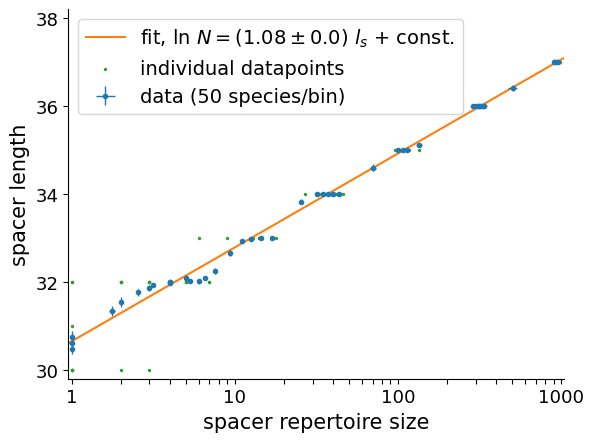

In [6]:
generate_scaling_plot(Nvec, lsvec)

### Plot Poisson distribution

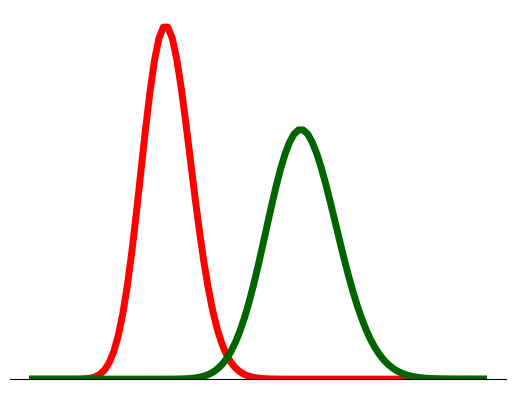

In [7]:
fig, ax = subplots()

xrange = 0:100
plot(xrange, pdf.(Poisson(30), xrange), linewidth=5, color="red")
plot(xrange, pdf.(Poisson(60), xrange), linewidth=5, color="darkgreen")

xticks([])
yticks([])

ymin, ymax = ylim()
ylim(0,ymax)

ax.spines["top"].set_visible(false)
ax.spines["left"].set_visible(false)
ax.spines["right"].set_visible(false)

# savefig("Poisson.svg",format="svg")

## Fig. 4B: geometric distribution

In [8]:
σ_mv = 0 # no noise
Ae = 5.5
μ_A = log(10.0^-Ae) # no noise

lsvec, Nvec = sampledata(2450, d_ls; distrib="geometric", σ_mv=σ_mv, Ae=Ae, μ_A=μ_A);

3.162277660168377e-60.0


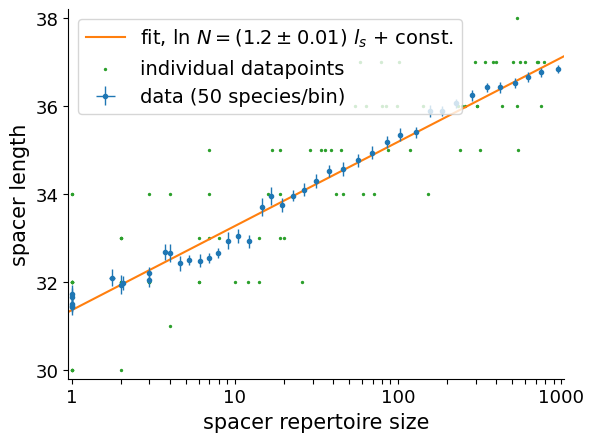

In [9]:
generate_scaling_plot(Nvec, lsvec)

### Plot geometric distribution

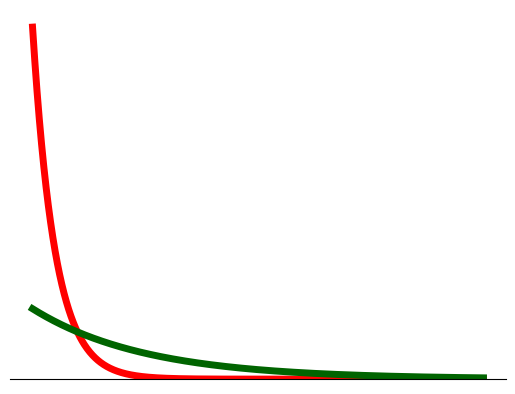

In [10]:
fig, ax = subplots()

xrange = 0:1000
plot(xrange, pdf.(Geometric(2e-2), xrange), linewidth=5, color="red")
plot(xrange, pdf.(Geometric(4e-3), xrange), linewidth=5, color="darkgreen")

xticks([])
yticks([])

ymin, ymax = ylim()
ylim(0,ymax)

ax.spines["top"].set_visible(false)
ax.spines["left"].set_visible(false)
ax.spines["right"].set_visible(false)

# savefig("geometric.svg",format="svg")

## Fig. S4C: geometric distribution with additional variability

In [11]:
σ_mv = 0.01 # with noise
Ae = 5.5
μ_A = log(2e-6) # with noise

lsvec, Nvec = sampledata(2450, d_ls; distrib="geometric", σ_mv=σ_mv, Ae=Ae, μ_A=μ_A);

3.162277660168377e-63.872983346207405e-6


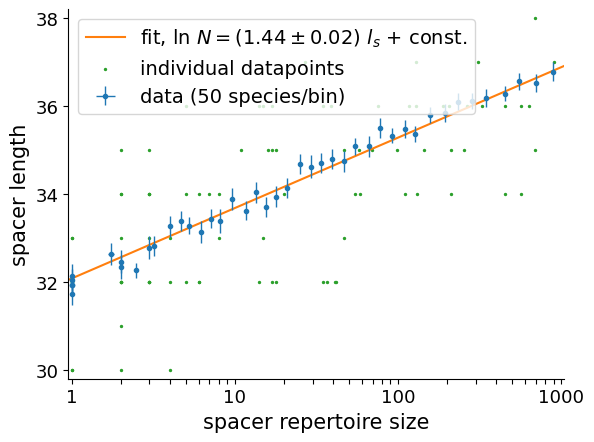

In [12]:
generate_scaling_plot(Nvec, lsvec)